In [1]:
import numpy as np

import sympy
from sympy import Symbol,sqrt

import matplotlib.pyplot as plt


import tensorflow as tf

import keras
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Sequential


from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from DeepLie_mods import *

from LieOperator import *
from Poisson import PoissonBracket
# 
import Factorization
from Factorization import factorization
from Factorization import taylor_to_weight_mat
from Factorization import taylorize

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

In [2]:
import random

from IPython.display import HTML


def hide_toggle(for_next=False):
    """
    Method to toggle the visibility
    of a single code input cell in Jupyter.
    Handy to use in combination with RISE for
    preseentations.
    Ref: https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
    """
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + ".next()"

    toggle_text = "Toggle show/hide"  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = (
        ""  # bit of JS to permanently hide code in current cell (only when toggling next cell)
    )

    if for_next:
        target_cell = next_cell
        toggle_text += " next cell"
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = "code_toggle_{}".format(str(random.randint(1, 2 ** 64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}
            {js_hide_current}
        </script>
        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current,
        toggle_text=toggle_text,
    )

    return HTML(html)

In [3]:
hide_toggle(for_next=True)

In [4]:
def make_rhs(_ham,_coords,_mom):
    _rhs = []
    for coord, mom in zip(_coords,_mom):
        _rhs.append(PoissonBracket(coord, _ham,coords=_coords,mom=_mom).doit())
        _rhs.append(PoissonBracket(mom, _ham,coords=_coords,mom=_mom).doit())
    
    return _rhs

def Ivanov_RK(k1,k2,l_d,l_qf,l_qd,_state, _order=1):
    

    exp_order = _order
    integrator_loops = 10


    state = np.array(_state)

    drift_rhs = make_rhs(H_drift,i_coord,i_mom)
    quadf_rhs = make_rhs(H_quad.subs(sym_k,k1),i_coord,i_mom)
    quadd_rhs = make_rhs(H_quad.subs(sym_k,k2),i_coord,i_mom)



    map_builder_drift = LieMapBuilder(state, drift_rhs, order=exp_order)
    R_drift = map_builder_drift.getInitR()
    R_drift = map_builder_drift.propogate(h=l_d/integrator_loops, N=integrator_loops, verbose=False)

    map_builder_quadf = LieMapBuilder(state, quadf_rhs, order=exp_order)
    R_quadf = map_builder_quadf.getInitR()
    R_quadf = map_builder_quadf.propogate(h=l_qf/integrator_loops, N=integrator_loops, verbose=False)

    map_builder_quadd = LieMapBuilder(state, quadd_rhs, order=exp_order)
    R_quadd = map_builder_quadd.getInitR()
    R_quadd = map_builder_quadd.propogate(h=l_qd/integrator_loops, N=integrator_loops, verbose=False)

    W_drift_RK = map_builder_drift.convert_weights_to_full_nn(R_drift)
    W_quadf_RK = map_builder_quadf.convert_weights_to_full_nn(R_quadf)
    W_quadd_RK = map_builder_quadd.convert_weights_to_full_nn(R_quadd)



    dim = len(state)  # predefined state vector dimension, contains physical parameters of a particle
    order = _order # predefined order of nonlinearity, order of Lie map

    

    Drift_RK = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadF_RK = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadD_RK = LieLayer(output_dim = dim, order = order, input_shape = (dim,))

    lattice = [QuadF_RK, Drift_RK, QuadD_RK, Drift_RK, QuadF_RK]

    # simply construct a neural network (computatuonal graph)
    fodo_RK = Sequential()
    for el in lattice:
        fodo_RK.add(el)

    Drift_RK.set_weights(W_drift_RK)
    QuadF_RK.set_weights(W_quadf_RK)
    QuadD_RK.set_weights(W_quadd_RK)
    
    
    W_drift_RK_corr = [W_drift_RK[0],correct_weigths(W_drift_RK[1]),W_drift_RK[2],W_drift_RK[3]]
    W_quadf_RK_corr = [W_quadf_RK[0],correct_weigths(W_quadf_RK[1]),W_quadf_RK[2],W_quadf_RK[3]]
    W_quadd_RK_corr = [W_quadd_RK[0],correct_weigths(W_quadd_RK[1]),W_quadd_RK[2],W_quadd_RK[3]]
    
    
    printlist(W_drift_RK_corr)
    printlist(W_quadf_RK_corr)
    printlist(W_quadd_RK_corr)
    

    Drift_RK_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadF_RK_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadD_RK_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))

    lattice = [QuadF_RK_corr, Drift_RK_corr, QuadD_RK_corr, Drift_RK_corr, QuadF_RK_corr]

    # simply construct a neural network (computatuonal graph)
    fodo_RK_corr = Sequential()
    for el in lattice:
        fodo_RK_corr.add(el)

    Drift_RK_corr.set_weights(W_drift_RK_corr)
    QuadF_RK_corr.set_weights(W_quadf_RK_corr)
    QuadD_RK_corr.set_weights(W_quadd_RK_corr)
    
    return fodo_RK, fodo_RK_corr

def drift(r,l):
    x = r[0]
    px = r[1]
    y = r[2]
    py = r[3]
    
    xn = x + l * px / np.sqrt(1 - px**2 - py**2)
    pxn = px
    yn = y + l * py / np.sqrt(1 - px**2 - py**2)
    pyn = py

    
    return xn, pxn, yn, pyn

def quadf(r,l,k):
    x = r[0]
    px = r[1]
    y = r[2]
    py = r[3]
    
    
    k = np.abs(k)

    
    omega = np.sqrt(k)
    sin = np.sin(omega*l)
    cos = np.cos(omega*l)
    sinh = np.sinh(omega * l)
    cosh = np.cosh(omega * l)
    
    xn = cos * x + sin * px / omega
    pxn = cos * px - sin * omega * x
    yn = cosh * y + sinh * py / omega
    pyn = sinh * omega * y + cosh * py
    
    return xn, pxn, yn, pyn

def quadff(r,l,k):
    x = r[0]
    px = r[1]
    y = r[2]
    py = r[3]
    
    
    
    k = np.abs(k)
    
    omega = np.sqrt(k)
    sin = np.sin(omega*l)
    cos = np.cos(omega*l)
    sinh = np.sinh(omega * l)
    cosh = np.cosh(omega * l)
    
    xn = cosh * x + sinh * px / omega
    pxn = cosh * px + sinh * omega * x
    yn = cos * y + sin * py / omega
    pyn = cos * py - sin * omega * y
    
    return xn, pxn, yn, pyn

def LieTracking(k1,k2,l_d,l_qf,l_qd,_order=2):
    taylor_order = _order

    H_quadf = H_quad.subs(sym_k,k1)
    H_quadd = H_quad.subs(sym_k,k2)

    L_drift = LieOperator(-l_d * H_drift,i_coord,i_mom)
    L_quadf = LieOperator(-l_qf * H_quadf,i_coord,i_mom)
    L_quadd = LieOperator(-l_qd * H_quadd,i_coord,i_mom)


    taylor_drift = taylorize(L_drift,taylor_order)

    taylor_quadf = taylorize(L_quadf,taylor_order)

    taylor_quadd = taylorize(L_quadd,taylor_order)
    
#     print(taylor_drift)
#     print(taylor_quadf)
#     print(taylor_quadd)
    
    nn_drift = taylor_to_weight_mat(taylor_drift)
    nn_quadf = taylor_to_weight_mat(taylor_quadf)
    nn_quadd = taylor_to_weight_mat(taylor_quadd)


    
#     corr_drift = correct_weights(M_taylor_drift[0])
    corr_qf = correct_weigths(nn_quadf[0])
    corr_qd = correct_weigths(nn_quadd[0])
    
    disp = np.array([[0,0,0,0]])


    W_drift_Lie = [disp] + nn_drift
    W_quadf_Lie = [disp] + nn_quadf
    W_quadd_Lie = [disp] + nn_quadd
    
    
    W_drift_Lie_corr = [disp] + nn_drift
    W_quadf_Lie_corr = [disp] + [corr_qf]
    W_quadd_Lie_corr = [disp] + [corr_qd]


    printlist(W_drift_Lie_corr)
    printlist(W_quadf_Lie_corr)
    printlist(W_quadd_Lie_corr)


    dim = len(tot_coords)


    # e.g. QFA helps focusing particle in radial direction, and QDA in vertical one
    Drift_Lie = LieLayer(output_dim = dim, order = len(nn_drift), input_shape = (dim,))
    QuadF_Lie = LieLayer(output_dim = dim, order = len(nn_quadf), input_shape = (dim,))
    QuadD_Lie = LieLayer(output_dim = dim, order = len(nn_quadd), input_shape = (dim,))

    lattice = [QuadF_Lie, Drift_Lie, QuadD_Lie, Drift_Lie, QuadF_Lie]

    # simply construct a neural network (computatuonal graph)
    fodo_Lie = Sequential()
    for el in lattice:
        fodo_Lie.add(el)

    Drift_Lie.set_weights(W_drift_Lie)
    QuadF_Lie.set_weights(W_quadf_Lie)
    QuadD_Lie.set_weights(W_quadd_Lie)
    
    

    Drift_Lie_corr = LieLayer(output_dim = dim, order = len(nn_drift), input_shape = (dim,))
    QuadF_Lie_corr = LieLayer(output_dim = dim, order = len(nn_quadf), input_shape = (dim,))
    QuadD_Lie_corr = LieLayer(output_dim = dim, order = len(nn_quadd), input_shape = (dim,))

    lattice = [QuadF_Lie_corr, Drift_Lie_corr, QuadD_Lie_corr, Drift_Lie_corr, QuadF_Lie_corr]

    # simply construct a neural network (computatuonal graph)
    fodo_Lie_corr = Sequential()
    for el in lattice:
        fodo_Lie_corr.add(el)

    Drift_Lie_corr.set_weights(W_drift_Lie_corr)
    QuadF_Lie_corr.set_weights(W_quadf_Lie_corr)
    QuadD_Lie_corr.set_weights(W_quadd_Lie_corr)
    
    return fodo_Lie, fodo_Lie_corr

def correct_weigths(M):
    m11 = M[0,0]
    m12 = M[0,1]
    m21 = M[1,0]
    m22 = M[1,1]
    
    error = np.linalg.norm(np.dot(M.T,np.dot(J,M)) - J)
    
    
                           
    
    if m11*m22 - m12*m21 != 1:
        print('Symplectic error: ', error)
        if m11 != 0:
            m22 = (1+m12*m21)/m11
        elif m21 != 0:
            m12 = (1-m11*m22)/m21
        elif m12 != 0:
            m21 = (1-m11*m22)/m12
        else:
            m11 = 1/m22
    else:
        print("The upper sub-matrix is symplectic.")
        
    m33 = M[2,2]
    m34 = M[2,3]
    m43 = M[3,2]
    m44 = M[3,3]
    
    if m33*m44 - m34*m43 != 1:
        if m33 != 0:
            m44 = (1+m34*m43)/m33
        elif m43 != 0:
            m34 = (1-m33*m44)/m43
        elif m43 != 0:
            m34 = (1-m33*m44)/m43
        else:
            m33 = 1/m44
    else:
        print("The lower sub-matrix is symplectic.")
    
    return np.array([[m11,m12,0,0],[m21,m22,0,0],[0,0,m33,m34],[0,0,m43,m44]])

def TrackFodo(r0,duration=100):
    X_RK = []
    X_Lie = []
    X_Lie_corr = []
    X_RK_corr = []

    X_Exact = []



    for pos in r0:
        X0 = np.array(pos).reshape((-1, 4))
        X_RK.append(X0)
        X_Lie.append(X0)
        X_Lie_corr.append(X0)
        X_RK_corr.append(X0)

        pos = np.array(pos)
        X_Exact.append(pos)

        for i in range(duration): 
            X_RK.append(fodo_RK.predict(X_RK[-1]))
            X_Lie.append(fodo_Lie.predict(X_Lie[-1]))
            X_Lie_corr.append(fodo_Lie_corr.predict(X_Lie_corr[-1]))
            X_RK_corr.append(fodo_RK_corr.predict(X_RK_corr[-1]))

            r = quadf(pos,_lqf,_k1)
            r = drift(r,_ld)
            r = quadff(r,_lqd,_k2)
            r = drift(r,_ld)
            r = quadf(r,_lqf,_k1)
            
            
            X_Exact.append(r)
            pos = np.copy(r)
            
    X_RK = np.array(X_RK)
    X_Lie = np.array(X_Lie)
    X_Lie_corr = np.array(X_Lie_corr)
    X_RK_corr = np.array(X_RK_corr)
    X_Exact = np.array(X_Exact)
    
    return X_RK, X_Lie, X_Exact, X_Lie_corr, X_RK_corr

# We are using the paraxial approximation for quads only and expand drift to fourth order (third order needs full 6d phase space)

$$ H_{drift} = \frac{p_{x}^{2} + p_{y}^{2}}{2} + \frac{p_{x}^{4}}{8} + \frac{p_{x}^{2} p_{y}^{2}}{4}  + \frac{p_{y}^{4}}{8} $$

$$ H_{quad} = \frac{p_x^2 + p_y^2}{2} + \frac{k_1}{2} (x^2 - y^2) $$

and will be looking at the FODO cell:

$$ \frac{1}{2} QF - D - QD - D - \frac{1}{2} QF$$

## and comparing it to Runge-Kutta and exact drift tracking through FODO

In [5]:
sym_x, sym_y, sym_z, sym_px, sym_py, sym_pz, sym_k, sym_l, sym_d = sympy.symbols('x y z p_x p_y delta k_{Q} L D')
J = np.array([[0,1,0,0],[-1,0,0,0],[0,0,0,1],[0,0,-1,0]])

In [6]:
i_coord = [sym_x,sym_y]
i_mom = [sym_px,sym_py]
tot_coords = [sym_x,sym_px,sym_y,sym_py]


approx_degree = 3
approx_degree_quad = 2

_epstemp = sympy.symbols('e')
full_drift = - sqrt(1 - _epstemp*(sym_px ** 2 + sym_py ** 2))


H_drift = full_drift.series(_epstemp,n=approx_degree).removeO().subs(_epstemp,1)


H_drift_quad = full_drift.series(_epstemp,n=approx_degree_quad).removeO().subs(_epstemp,1)
H_quad = H_drift_quad + sym_k*(sym_x**2 - sym_y**2)/2

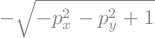

In [7]:
full_drift.subs(_epstemp,1)

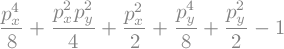

In [8]:
H_drift

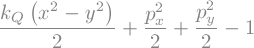

In [9]:
H_quad

In [10]:
_k1 = 0.5
_k2 = -0.5
delta = 0

_ld = 2.5
_lqf = 0.25
_lqd = 0.5




_r0 = [[10e-7,0,10e-7,0],
       [10e-4,0,10e-4,0],
       [0.1,0,0.1,0],
       [0.25,0,0.25,0],
       [0.5,0,0.5,0],
       [1,0,1,0],
       [2,0,2,0]]

In [11]:
fodo_RK, fodo_RK_corr = Ivanov_RK(_k1,_k2,_ld,_lqf,_lqd,tot_coords,_order=3)
fodo_Lie, fodo_Lie_corr = LieTracking(_k1,_k2,_ld,_lqf,_lqd,_order=4)

[x p_x y p_y]
[p_x**3/2 + p_x*p_y**2/2 + p_x, 0, p_x**2*p_y/2 + p_y**3/2 + p_y, 0]
[x p_x y p_y]
[p_x, -0.5*x, p_y, 0.5*y]
[x p_x y p_y]
[p_x, 0.5*x, p_y, -0.5*y]
The upper sub-matrix is symplectic.
The lower sub-matrix is symplectic.
Symplectic error:  0.0010416666826491077
Symplectic error:  0.00416666768956972
[[0. 0. 0. 0.]]
[[1.  0.  0.  0. ]
 [2.5 1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  2.5 1. ]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.  

In [12]:
X_RK, X_Lie, X_Exact, X_Lie_corr, X_RK_corr = TrackFodo(_r0,1000)

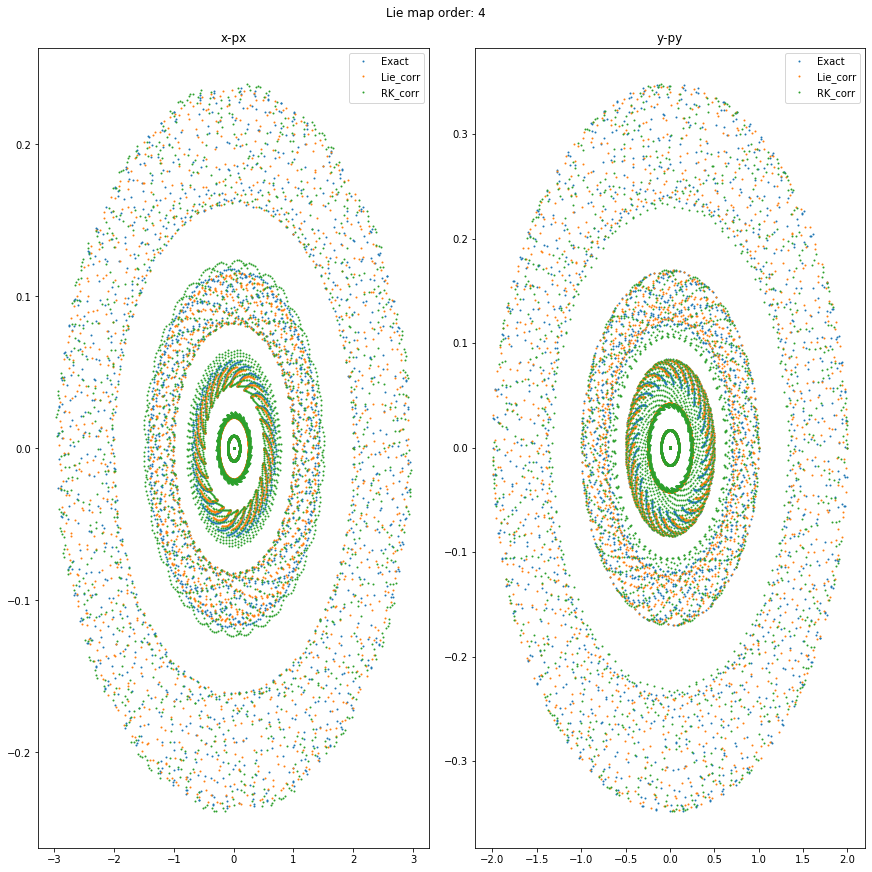

In [17]:
# subplot grid
fig = plt.figure(constrained_layout=True, figsize = (12,12))
gs  = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])


ax1.set_title('x-px')
ax2.set_title('y-py')

# ax1.plot(X_RK[:, 0, 0], X_RK[:, 0, 1], '.', markersize = 2,label='RK') 
# ax2.plot(X_RK[:, 0, 2], X_RK[:, 0, 3], '.', markersize = 2,label='RK')


# ax1.plot(X_Lie[:, 0, 0], X_Lie[:, 0, 1], '.', markersize = 2,label='Lie')
# ax2.plot(X_Lie[:, 0, 2], X_Lie[:, 0, 3], '.', markersize = 2,label='Lie')

ax1.plot(X_Exact[:, 0], X_Exact[:, 1], '.', markersize = 2,label='Exact')
ax2.plot(X_Exact[:, 2], X_Exact[:, 3], '.', markersize = 2,label='Exact')


ax1.plot(X_Lie_corr[:, 0, 0], X_Lie_corr[:, 0, 1], '.', markersize = 2,label='Lie_corr')
ax2.plot(X_Lie_corr[:, 0, 2], X_Lie_corr[:, 0, 3], '.', markersize = 2,label='Lie_corr')

ax1.plot(X_RK_corr[:, 0, 0], X_RK_corr[:, 0, 1], '.', markersize = 2,label='RK_corr')
ax2.plot(X_RK_corr[:, 0, 2], X_RK_corr[:, 0, 3], '.', markersize = 2,label='RK_corr')

ax1.legend()
ax2.legend()

plt.suptitle("Lie map order: 4")
# plt.savefig('LieMapOrder_5_RK.png')

plt.show()